In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import anndata as ad
import matplotlib.pyplot as plt
import seaborn as sns
from importlib import reload
from itertools import chain
from scipy.sparse import csr_matrix

import utils_guide_calling as gc

In [2]:
reload(gc)

<module 'utils_guide_calling' from '/Users/janabraunger/Documents/Projects/scCRISPR/crispat_analysis/python/utils_guide_calling.py'>

In [3]:
data_dir = "../../data/"
gc_dir = "../../data/guide_calling/"
fig_dir = "../../figures/guide_calling/"

# Prerequisites

In [4]:
# Annotation for each gRNA containing the name of the target gene, its ensembl id and the target sequence
anno = pd.read_csv(data_dir + 'Replogle/K562_essential_processed_annotation.csv')
anno = anno[['full_gRNA', 'gRNA_pair_id', 'target_gene']]
anno = anno.rename(columns={'full_gRNA':'individual_gRNA', 'gRNA_pair_id': 'gRNA'})
anno.to_csv(data_dir + 'Replogle/K562_gRNA_target_df.csv', index = False)

In [5]:
# Load data excluding cells with too few total counts (<3000) or too many mitochondrial genes (>20%)
filtered_data = sc.read_h5ad(data_dir+'Replogle/Replogle_K562_essential/filtered_data_all-batches.h5ad')

# Get list of all gRNAs used by Replogle et al.
replogle = sc.read_h5ad(data_dir + 'Replogle/K562_essential_raw_singlecell_01.h5ad')
all_gRNAs = list(chain.from_iterable([gRNAs.split('|') for gRNAs in replogle.obs['sgID_AB']]))
gRNA_pairs = list(replogle.obs['gene_transcript'].unique())

In [6]:
# create gRNA target df for the summed gRNA experiment
df = pd.read_csv(data_dir + 'Replogle/Replogle_K562_essential/Replogle_K562_500_gRNA_groups.csv')
df = df[['gRNA_pair_id', 'group', 'control']].rename(columns = {'gRNA_pair_id': 'gRNA'})
df = df.merge(anno[['individual_gRNA', 'gRNA']])
df = df[['individual_gRNA', 'group', 'control']].rename(columns = {'group': 'gRNA'})
df.to_csv(data_dir + 'Replogle/Replogle_K562_essential/Replogle_K562_500_gRNA_target_df.csv', index = False)

# K562 cells

In [7]:
# Varying ratios
print('varying ratios')
ratios = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
ratio_perturbations = pd.DataFrame()
for ratio in ratios: 
    ratio_cells = pd.read_csv(gc_dir + 'Replogle_K562/ratios/perturbations_t' + str(ratio) + '.csv')[['cell', 'gRNA']]
    ratio_cells['method'] = ratio * 100
    ratio_perturbations = pd.concat([ratio_perturbations, ratio_cells])
ratio_counts = ratio_perturbations.groupby(['method']).size().reset_index(name = 'n_cells')
ratio_counts.to_csv(gc_dir + 'Replogle_K562/ratios/all_assignments.csv', index = False)

# Varying UMI threshold
print('varying UMIs')
UMI_ts = [2,5,10,15,20,30,40,50,60,80,100,120,140,160,180,200]
UMI_perturbations = pd.DataFrame()
for t in UMI_ts: 
    UMI_cells = pd.read_csv(gc_dir + 'Replogle_K562/UMI/perturbations_t' + str(t) + '.csv')[['cell', 'gRNA']]
    UMI_cells['method'] = t
    UMI_perturbations = pd.concat([UMI_perturbations, UMI_cells])
UMI_counts = UMI_perturbations.groupby(['method']).size().reset_index(name = 'n_cells')
UMI_counts.to_csv(gc_dir + 'Replogle_K562/UMI/all_assignments.csv', index = False)

# Varying quantile threshold
print('varying quantiles')
quantile_ts = [0.01, 0.025, 0.05, 0.075, 0.1, 0.2, 0.3, 0.4, 0.5]
q_perturbations = pd.DataFrame()
for t in quantile_ts: 
    q_cells = pd.read_csv(gc_dir + 'Replogle_K562/quantiles/perturbations_q' + str(t) + '.csv')[['cell', 'gRNA']]
    q_cells['method'] = t * 100
    q_perturbations = pd.concat([q_perturbations, q_cells])
q_counts = q_perturbations.groupby(['method']).size().reset_index(name = 'n_cells')
q_counts.to_csv(gc_dir + 'Replogle_K562/quantiles/all_assignments.csv', index = False)
    
# Filter to single assignments
print('filter for cells with single assignment')
ratio_single_perturbations = gc.get_single_assignments(ratio_perturbations)
ratio_counts = ratio_single_perturbations.groupby(['method']).size().reset_index(name = 'n_cells')
ratio_counts.to_csv(gc_dir + 'Replogle_K562/ratios/single_assignments.csv', index = False)

UMI_single_perturbations = gc.get_single_assignments(UMI_perturbations)
UMI_counts = UMI_single_perturbations.groupby(['method']).size().reset_index(name = 'n_cells')
UMI_counts.to_csv(gc_dir + 'Replogle_K562/UMI/single_assignments.csv', index = False)

q_single_perturbations = gc.get_single_assignments(q_perturbations)
q_counts = q_single_perturbations.groupby(['method']).size().reset_index(name = 'n_cells')
q_counts.to_csv(gc_dir + 'Replogle_K562/quantiles/single_assignments.csv', index = False)

varying ratios
varying UMIs
varying quantiles
filter for cells with single assignment


In [10]:
# Load all assignments
k562_dir = gc_dir + "Replogle_K562/"
gc_dict = {'2-Beta': '2-BetaMM', '3-Beta': '3-BetaMM', 'Binomial': 'binomial', 
           'Cell Ranger': 'cellranger', 'Maximum': 'maximum', 'Negative Binomial': 'negative_binomial', 
           'Poisson-Gauss': 'Replogle', 'Poisson': 'SCEPTRE'}

perturbations = pd.DataFrame()
for name, method_dir in gc_dict.items():
    assignment = pd.read_csv(k562_dir + method_dir + '/perturbations.csv')[['cell', 'gRNA']]
    assignment['method'] = name

    # Combine with all others
    perturbations = pd.concat([perturbations, assignment])
    
# Add assignments from varying t methods
UMI_t30 = UMI_perturbations[UMI_perturbations['method'] == 30]
UMI_t30['method'] = 'UMI_t30'
ratio_t50 = ratio_perturbations[ratio_perturbations['method'] == 50]
ratio_t50['method'] = 'ratio_50%'
q5 = q_perturbations[q_perturbations['method'] == 5]
q5['method'] = 'top_5%_cells'

perturbations = pd.concat([perturbations, UMI_t30, ratio_t50, q5])

/var/folders/t4/w5mqv6rs3fs30q19lndp5b800000gn/T/ipykernel_59732/3312789043.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  UMI_t30['method'] = 'UMI_t30'
/var/folders/t4/w5mqv6rs3fs30q19lndp5b800000gn/T/ipykernel_59732/3312789043.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratio_t50['method'] = 'ratio_50%'
/var/folders/t4/w5mqv6rs3fs30q19lndp5b800000gn/T/ipykernel_59732/3312789043.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[

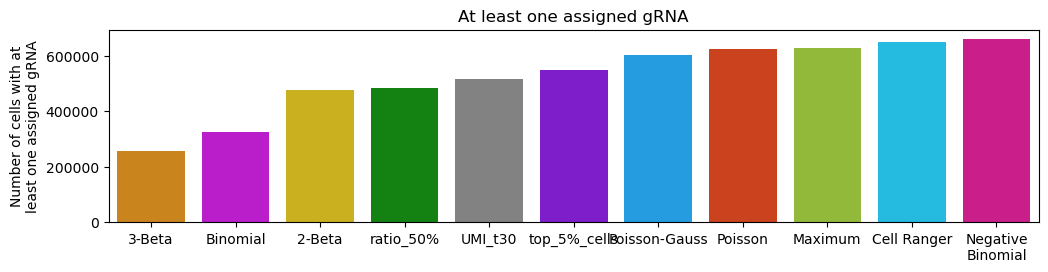

In [11]:
# Number of cells with at least one gRNA assignment
n_assignments_per_method = perturbations[['method', 'cell']].drop_duplicates().groupby(['method']).size().reset_index(name='count')
n_assignments_per_method = n_assignments_per_method.sort_values(by='count')
n_assignments_per_method.loc[n_assignments_per_method['method'] == 'Negative Binomial', 'method'] = 'Negative\nBinomial'

colors = pd.read_csv(data_dir + 'sceptre_pipeline/Replogle_K562/colors.csv')
colors = colors.set_index('method')['colors'].to_dict()
colors['Negative\nBinomial'] = colors.pop('Negative Binomial')

plt.figure(figsize = (12, 2.5))
sns.barplot(data = n_assignments_per_method, x = "method", y = "count", palette = colors)
plt.xlabel('')
plt.ylabel('Number of cells with at\nleast one assigned gRNA')
plt.title('At least one assigned gRNA')
plt.savefig(fig_dir + 'K562_total_assignments.png', dpi = 500, bbox_inches="tight")
plt.show()

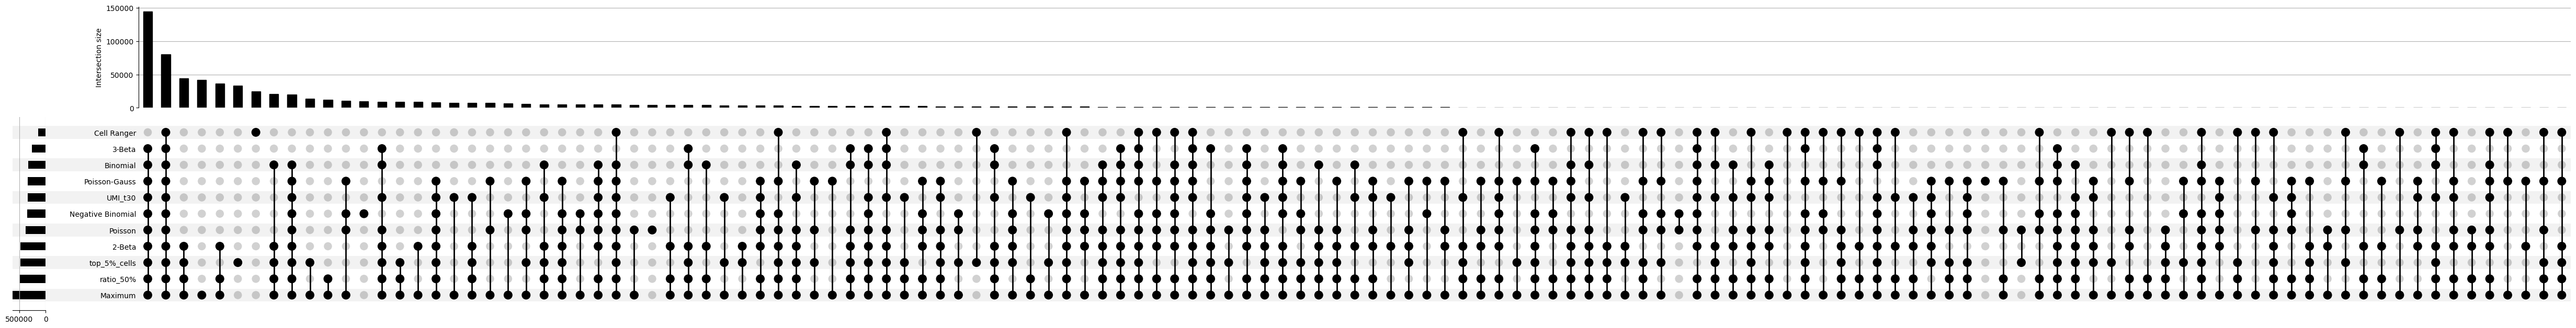

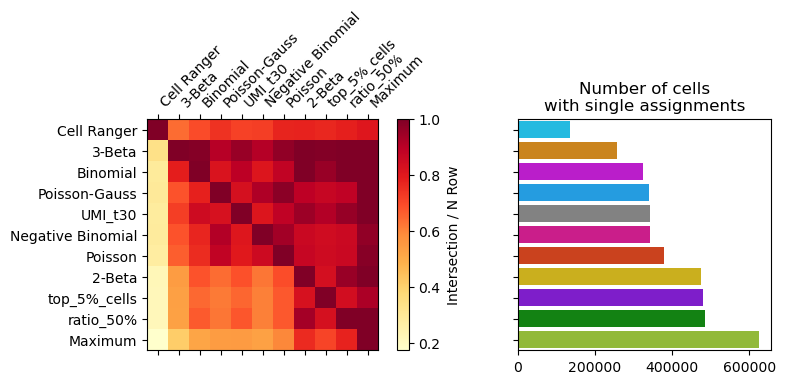

In [12]:
# Intersections of cells with single perturbations

# Filtering for cells with single perturbations
grouped_df = perturbations[['method', 'cell', 'gRNA']].drop_duplicates()
grouped_df = grouped_df.groupby(['method', 'cell']).size().reset_index(name='pert_count')
filtered_df = perturbations.merge(grouped_df, on=['method', 'cell'])
filtered_df = filtered_df[filtered_df['pert_count'] == 1]

# Upset plot
gc.plot_intersections(filtered_df)
plt.savefig(fig_dir + 'guide_calling_single_intersections.png', dpi = 500, bbox_inches="tight")
plt.show()

# Heatmap
colors = pd.read_csv(data_dir + 'sceptre_pipeline/Replogle_K562/colors.csv')
colors = colors.set_index('method')['colors'].to_dict()
gc.plot_intersection_heatmap(filtered_df, colors)
plt.savefig(fig_dir + 'guide_calling_single_intersections_heatmap.png', dpi = 500, bbox_inches="tight")
plt.show()

In [13]:
# add target gene annotation
anno_sub = anno[['gRNA', 'target_gene']].drop_duplicates()
filtered_df = filtered_df.merge(anno_sub)
# save single assigned cell df for usage in R
selected_df = filtered_df.loc[:, ['cell', 'gRNA', 'target_gene', 'method']].drop_duplicates()
selected_df.to_csv(gc_dir+'Replogle_K562/single_assignments_all_methods.csv', index = False)

In [14]:
perturbations[['method', 'cell', 'gRNA']].drop_duplicates().to_csv(gc_dir+'Replogle_K562/all_assignments_all_methods.csv', index = False)

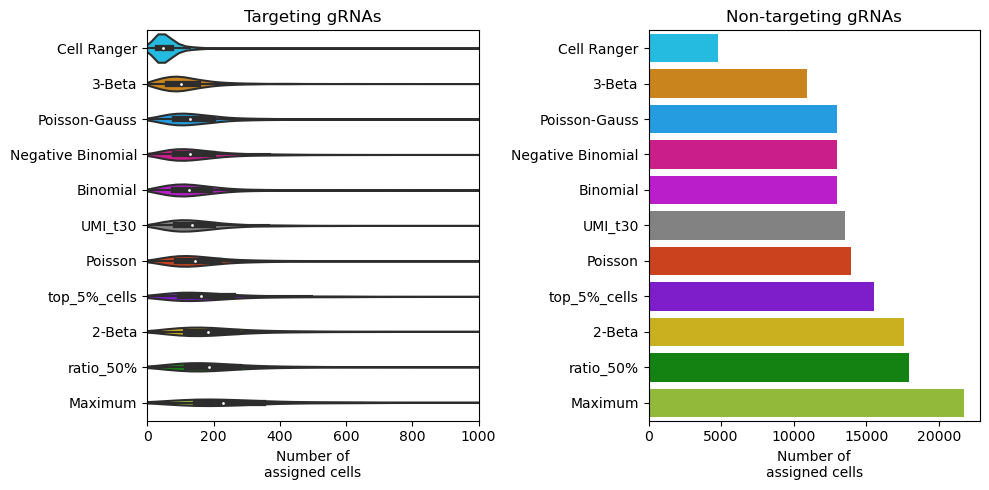

In [15]:
targeting = filtered_df[filtered_df['target_gene'] != 'non-targeting']
non_targeting = filtered_df[filtered_df['target_gene'] == 'non-targeting']

fig, axs = plt.subplots(figsize = (10, 5), nrows = 1, ncols = 2)

# create barplot of the total number non-targeting control cells per method
nt = non_targeting[['cell', 'method']].drop_duplicates().groupby('method').size().reset_index(name='cells')
nt = nt.sort_values(by='cells')
sns.barplot(data = nt, y = "method", x = "cells", palette = colors, ax = axs[1])
axs[1].set_ylabel('')
axs[1].set_xlabel('Number of\nassigned cells')
axs[1].set_title('Non-targeting gRNAs')

# create boxplots of the number of cells per perturbation
targeting = targeting[['cell', 'gRNA', 'target_gene', 'method']].drop_duplicates()
targeting = targeting.groupby(['method', 'target_gene']).size().reset_index(name = 'cells')
sns.violinplot(data = targeting, y = "method", x = "cells", palette = colors, ax = axs[0], order = nt['method'])
axs[0].set_xlim(0, 1000)
axs[0].set_ylabel('')
axs[0].set_xlabel('Number of\nassigned cells')
axs[0].set_title('Targeting gRNAs')

plt.tight_layout()
plt.savefig(fig_dir + 'n_assigned_cells.png', dpi = 500, bbox_inches="tight")
plt.show()

In [16]:
# use control cells from maximum assignment for all methods
control_cells = non_targeting.loc[non_targeting['method'] == 'Maximum', ['cell', 'gRNA']]

def add_fixed_control(method, control_cells, save_dir):
    perturbed_cells = filtered_df.loc[(filtered_df['target_gene'] != 'non-targeting') & 
                                      (filtered_df['method'] == method), ['cell', 'gRNA']]
    perturbed_cells = pd.concat([perturbed_cells, control_cells])
    perturbed_cells.to_csv(save_dir+'perturbations_max_control.csv', index = False)
    
add_fixed_control('Cell Ranger', control_cells, gc_dir + 'Replogle_K562/cellranger/')
add_fixed_control('3-Beta', control_cells, gc_dir + 'Replogle_K562/3-BetaMM/')
add_fixed_control('Poisson-Gauss', control_cells, gc_dir + 'Replogle_K562/Replogle/')
add_fixed_control('Negative Binomial', control_cells, gc_dir + 'Replogle_K562/negative_binomial/')
add_fixed_control('Binomial', control_cells, gc_dir + 'Replogle_K562/binomial/')
add_fixed_control('UMI_t30', control_cells, gc_dir + 'Replogle_K562/UMI/')
add_fixed_control('Poisson', control_cells, gc_dir + 'Replogle_K562/SCEPTRE/')
add_fixed_control('top_5%_cells', control_cells, gc_dir + 'Replogle_K562/quantiles/')
add_fixed_control('2-Beta', control_cells, gc_dir + 'Replogle_K562/2-BetaMM/')
add_fixed_control('ratio_50%', control_cells, gc_dir + 'Replogle_K562/ratios/')

# Replogle RPE1 cells

In [17]:
import import_Replogle_RPE1 as rpe

anno = rpe.get_anno(data_dir + "Replogle/")
# add full gRNA names (incl _posA or _posB)
full_gRNAs = sc.read_10x_mtx(data_dir + 'Replogle/Replogle_RPE1/batch1/', 
                             var_names='gene_symbols', gex_only = False, prefix = '') 
full_gRNAs = full_gRNAs[:, full_gRNAs.var["feature_types"] == "CRISPR Guide Capture"].var_names.tolist()
anno = anno.merge(pd.DataFrame({'full_gRNA': full_gRNAs, 'gRNA': [gRNA[:-5] for gRNA in full_gRNAs]}))

anno = anno[['full_gRNA', 'gRNA_pair_id', 'target_gene']]
anno = anno.rename(columns={'full_gRNA':'individual_gRNA', 'gRNA_pair_id': 'gRNA'})
#anno.to_csv(data_dir + "Replogle/RPE1_gRNA_target_df.csv", index = False)

In [18]:
# Varying ratios
print('varying ratios')
ratios = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
ratio_perturbations = pd.DataFrame()
for ratio in ratios: 
    ratio_cells = pd.read_csv(gc_dir + 'Replogle_RPE1/ratios/perturbations_t' + str(ratio) + '.csv')[['cell', 'gRNA']]
    ratio_cells['method'] = ratio * 100
    ratio_perturbations = pd.concat([ratio_perturbations, ratio_cells])
ratio_counts = ratio_perturbations.groupby(['method']).size().reset_index(name = 'n_cells')
ratio_counts.to_csv(gc_dir + 'Replogle_RPE1/ratios/all_assignments.csv', index = False)

# Varying UMI threshold
print('varying UMIs')
UMI_ts = [2,3,4,5,10,20,30,40,60,80,100,120,140,160,180,200,250,300,350,400,450,500]
UMI_perturbations = pd.DataFrame()
for t in UMI_ts: 
    UMI_cells = pd.read_csv(gc_dir + 'Replogle_RPE1/UMI/perturbations_t' + str(t) + '.csv')[['cell', 'gRNA']]
    UMI_cells['method'] = t
    UMI_perturbations = pd.concat([UMI_perturbations, UMI_cells])
UMI_counts = UMI_perturbations.groupby(['method']).size().reset_index(name = 'n_cells')
UMI_counts.to_csv(gc_dir + 'Replogle_RPE1/UMI/all_assignments.csv', index = False)

# Varying quantile threshold
print('varying quantiles')
quantile_ts = [0.01, 0.025, 0.05, 0.075, 0.1, 0.2, 0.3]
q_perturbations = pd.DataFrame()
for t in quantile_ts: 
    q_cells = pd.read_csv(gc_dir + 'Replogle_RPE1/quantiles/perturbations_q' + str(t) + '.csv')[['cell', 'gRNA']]
    q_cells['method'] = t * 100
    q_perturbations = pd.concat([q_perturbations, q_cells])
q_counts = q_perturbations.groupby(['method']).size().reset_index(name = 'n_cells')
q_counts.to_csv(gc_dir + 'Replogle_RPE1/quantiles/all_assignments.csv', index = False)
    
# Filter to single assignments
print('filter for cells with single assignment')
ratio_single_perturbations = gc.get_single_assignments(ratio_perturbations)
ratio_counts = ratio_single_perturbations.groupby(['method']).size().reset_index(name = 'n_cells')
ratio_counts.to_csv(gc_dir + 'Replogle_RPE1/ratios/single_assignments.csv', index = False)

UMI_single_perturbations = gc.get_single_assignments(UMI_perturbations)
UMI_counts = UMI_single_perturbations.groupby(['method']).size().reset_index(name = 'n_cells')
UMI_counts.to_csv(gc_dir + 'Replogle_RPE1/UMI/single_assignments.csv', index = False)

q_single_perturbations = gc.get_single_assignments(q_perturbations)
q_counts = q_single_perturbations.groupby(['method']).size().reset_index(name = 'n_cells')
q_counts.to_csv(gc_dir + 'Replogle_RPE1/quantiles/single_assignments.csv', index = False)

varying ratios
varying UMIs
varying quantiles
filter for cells with single assignment


In [19]:
# Load all assignments
rpe_dir = gc_dir + "Replogle_RPE1/"
gc_dict = {'2-Beta': '2-Beta_MM', '3-Beta': '3-Beta_MM', 'Binomial': 'binomial', 
           'Cell Ranger': 'cellranger', 'Maximum': 'maximum', 'Negative Binomial': 'negative_binomial', 
           'Poisson-Gauss': 'Replogle', 'Poisson': 'SCEPTRE'}

perturbations = pd.DataFrame()
for name, method_dir in gc_dict.items():
    assignment = pd.read_csv(rpe_dir + method_dir + '/perturbations.csv')[['cell', 'gRNA']]
    assignment['method'] = name

    # Combine with all others
    perturbations = pd.concat([perturbations, assignment])
    
# Add assignments from varying t methods
UMI_t140 = UMI_perturbations[UMI_perturbations['method'] == 140]
UMI_t140['method'] = 'UMI_t140'
ratio_t40 = ratio_perturbations[ratio_perturbations['method'] == 40]
ratio_t40['method'] = 'ratio_40%'
q5 = q_perturbations[q_perturbations['method'] == 5]
q5['method'] = 'top_5%_cells'

perturbations = pd.concat([perturbations, UMI_t140, ratio_t40, q5])

/var/folders/t4/w5mqv6rs3fs30q19lndp5b800000gn/T/ipykernel_59732/2220654627.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  UMI_t140['method'] = 'UMI_t140'
/var/folders/t4/w5mqv6rs3fs30q19lndp5b800000gn/T/ipykernel_59732/2220654627.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratio_t40['method'] = 'ratio_40%'
/var/folders/t4/w5mqv6rs3fs30q19lndp5b800000gn/T/ipykernel_59732/2220654627.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .lo

In [20]:
# Intersections of cells with single perturbations

# Filtering for cells with single perturbations
grouped_df = perturbations.drop_duplicates()
grouped_df = grouped_df.groupby(['method', 'cell']).size().reset_index(name='pert_count')
filtered_df = perturbations.merge(grouped_df, on=['method', 'cell'])
filtered_df = filtered_df[filtered_df['pert_count'] == 1]

# add target gene annotation
anno_sub = anno[['gRNA', 'target_gene']].drop_duplicates()
filtered_df = filtered_df.merge(anno_sub)
filtered_df.to_csv(gc_dir+'Replogle_RPE1/single_assignments_all_methods.csv', index = False)

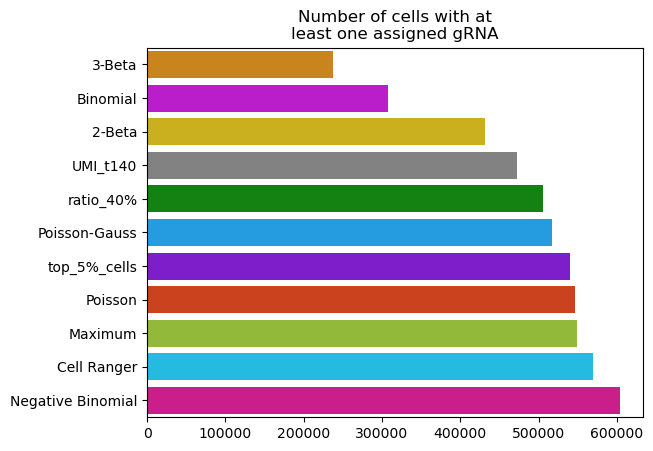

In [21]:
# Number of cells with assignment
n_assignments_per_method = perturbations[['method', 'cell']].drop_duplicates().groupby(['method']).size().reset_index(name='count')
n_assignments_per_method = n_assignments_per_method.sort_values(by='count')

colors = pd.read_csv(data_dir + 'sceptre_pipeline/Replogle_RPE1/colors.csv')
colors = colors.set_index('method')['colors'].to_dict()

sns.barplot(data = n_assignments_per_method, y = "method", x = "count", palette = colors)
plt.xlabel('')
plt.ylabel('')
plt.title('Number of cells with at\nleast one assigned gRNA')
plt.savefig(fig_dir + 'RPE1_total_assignments.png', dpi = 500, bbox_inches="tight")
plt.show()

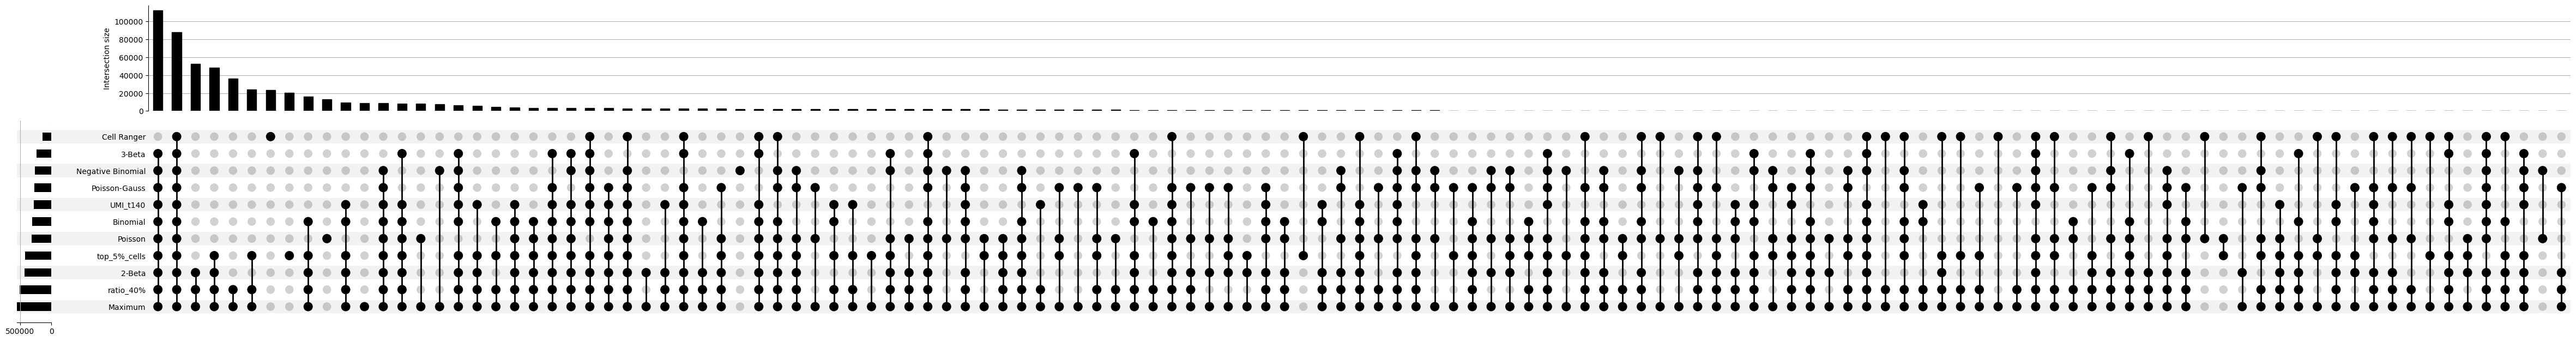

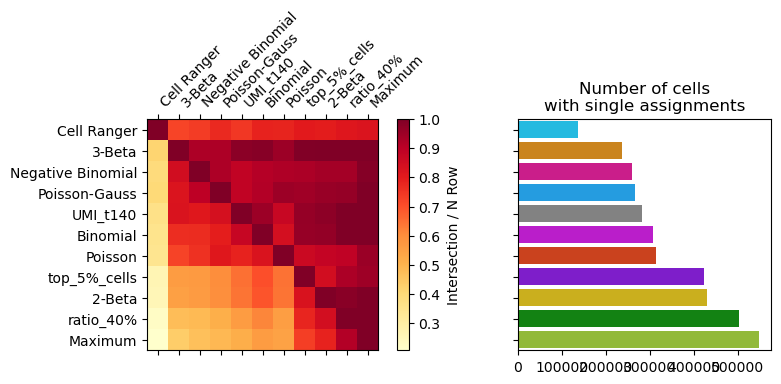

In [22]:
# Upset plot
gc.plot_intersections(filtered_df)
plt.savefig(fig_dir + 'RPE1_gc_single_intersections.png', dpi = 500, bbox_inches="tight")
plt.show()

# Heatmap
colors = pd.read_csv(data_dir + 'sceptre_pipeline/Replogle_RPE1/colors.csv')
colors = colors.set_index('method')['colors'].to_dict()
gc.plot_intersection_heatmap(filtered_df, colors)
plt.savefig(fig_dir + 'RPE1_gc_single_heatmap.png', dpi = 500, bbox_inches="tight")
plt.show()

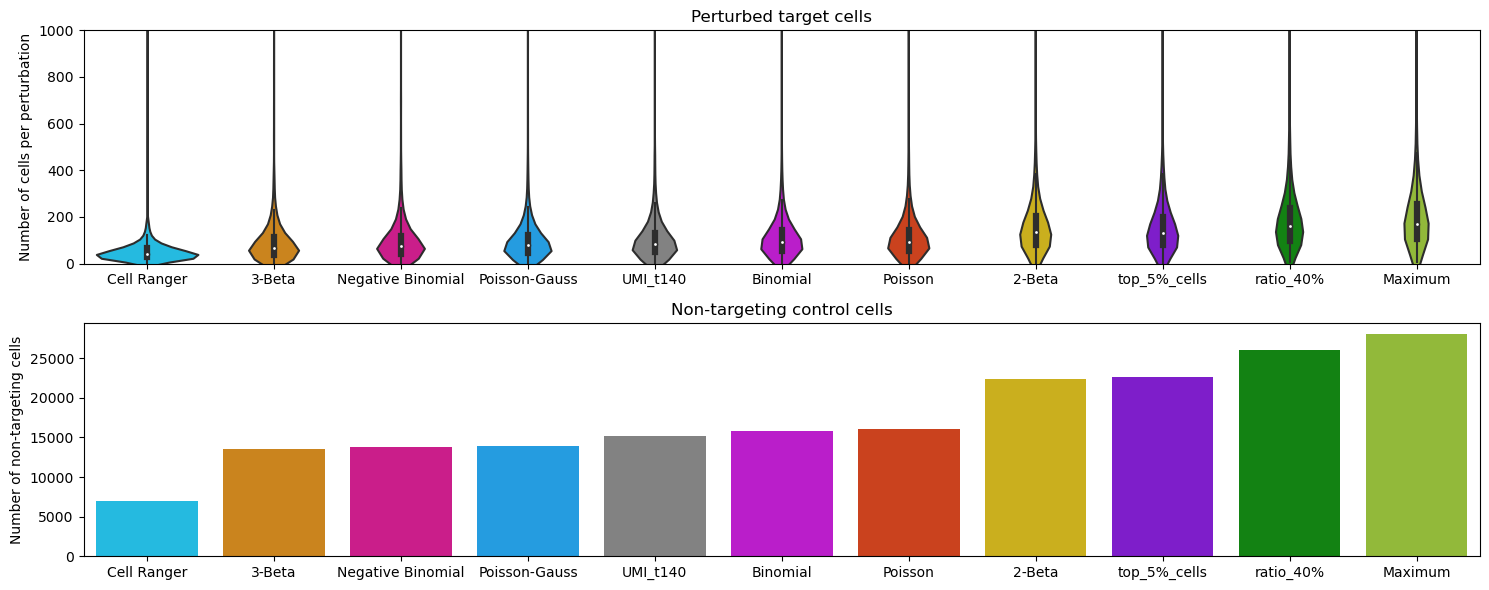

In [23]:
targeting = filtered_df[filtered_df['target_gene'] != 'non-targeting']
non_targeting = filtered_df[filtered_df['target_gene'] == 'non-targeting']

fig, axs = plt.subplots(figsize = (15, 6), nrows = 2, ncols = 1)

# create barplot of the total number non-targeting control cells per method
nt = non_targeting[['cell', 'method']].drop_duplicates().groupby('method').size().reset_index(name='cells')
nt = nt.sort_values(by='cells')
sns.barplot(data = nt, x = "method", y = "cells", palette = colors, ax = axs[1])
axs[1].set_xlabel('')
axs[1].set_ylabel('Number of non-targeting cells')
axs[1].set_title('Non-targeting control cells')

# create boxplots of the number of cells per perturbation
targeting = targeting.groupby(['method', 'target_gene']).size().reset_index(name = 'cells')
sns.violinplot(data = targeting, x = "method", y = "cells", palette = colors, ax = axs[0], order = nt['method'])
axs[0].set_ylim(0, 1000)
axs[0].set_xlabel('')
axs[0].set_ylabel('Number of cells per perturbation')
axs[0].set_title('Perturbed target cells')

plt.tight_layout()
plt.savefig(fig_dir + 'RPE1_n_assigned_cells.png', dpi = 500, bbox_inches="tight")
plt.show()